In [1]:
import numpy as np
import pickle 
import itertools 

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ACTIVE_REGIONS = ['11158','11875','11890','12002','12192','12297']
NON_ACTIVE_REGIONS = ['11497','11663','11863','12134','12305','12427']

class text_style:
    BOLD = "\033[1m"
    END = "\033[0m"

In [2]:
## Pickle objects 

## Active Regions counts 
arc_file = open('resources/ar_counts.pkl', 'rb')
AR_COUNTS = pickle.load(arc_file)
arc_file.close()

## Observed Flare counts 
oc_file = open('resources/obs_counts.pkl', 'rb')
OBS_COUNTS = pickle.load(oc_file)
oc_file.close()

## Original Fits image data shape / size
ds_file = open('resources/d_shape.pkl', 'rb')
D_SHAPE = pickle.load(ds_file)
ds_file.close()

## Jordans Prediction Results 
jpr_file = open('resources/jpred_results.pkl', 'rb')
JP_RESULTS = pickle.load(jpr_file)
jpr_file.close()

## CNN Prediction Results 
cpr_file = open('resources/cpred_results.pkl', 'rb')
CP_RESULTS = pickle.load(cpr_file, encoding='latin1')
cpr_file.close()

## CNN Accuracy Results 
cr_file = open('resources/cnn_results.pkl', 'rb')
CNN_RESULTS = pickle.load(cr_file, encoding='latin1')
cr_file.close()

## CNN Full Dataset Prediction 
cfp_file = open('resources/cnn_fullpred.pkl', 'rb')
CNN_FULL_PRED = pickle.load(cfp_file, encoding='latin1')
cfp_file.close()

# Active Region Dataset
The active region dataset consists of 12 folders with each folder respresenting an active region (AR) for a given timeframe.  The dataset is split in two whereby 6 folders represent active regions that produce one or more flares, while the other 6 folders represent active regions that do not produce any flare.  

Active Region ID | Flare Observed (\*) | Timeframe (After Processing)
:----:|:----:|:----:|
11158 | True | 10.02.2011 (22:00) - 19.02.2011 (19:48)
11497 | False | 31.05.2012 (12:36) - 10.06.2012 (08:00)
11663 | False | 24.01.2013 (19:48) - 04.02.2013 (18:48)
11863 | False | 06.10.2013 (09:48) - 16.10.2013 (04:24)
11875 | True | 18.10.2013 (04:36) - 28.10.2013 (18:48)
11890 | True | 03.11.2013 (16:36) - 14.11.2013 (03:48)
12002 | True | 08.03.2014 (09:12) - 19.03.2014 (13:12)
12134 | False | 03.08.2014 (08:36) - 13.08.2014 (19:36)
12192 | True | 19.10.2014 (07:00) - 28.10.2014 (03:00)
12297 | True | 08.03.2015 (00:48) - 18.03.2015 (20:00)
12305 | False | 22.03.2015 (00:24) - 31.03.2015 (13:24)
12427 | False | 26.09.2015 (23:48) - 07.10.2015 (15:24)


## Data Analysis & Processing 
Each of the folders contains a collection of images (represented in fits format).  Images within the active regions were taken 12 minutes apart and so an active region can represent solar surface activity across a number of days as shown in the table timeframes above.  Not all images contained within these folders were of solar surface activity and as such the dataset required some processing.  This involved the removal of a number of junk images at both the beginning and end of each of the active regions, these junk images did not depict any solar information and instead represented graph readings.  

The number of images within each of the active regions upon completing this processing is as follows:

In [3]:
## Uses ar_counts.pkl
for ar_id in sorted(AR_COUNTS.keys()):
    print("\t\t\t\t\tAR_"+ar_id+": "+str(AR_COUNTS[ar_id]))

					AR_11158: 950
					AR_11497: 1134
					AR_11663: 1135
					AR_11863: 1131
					AR_11875: 1119
					AR_11890: 1129
					AR_12002: 1054
					AR_12134: 1253
					AR_12192: 909
					AR_12297: 1042
					AR_12305: 1137
					AR_12427: 1275


The sizes as shown below are the original image array sizes / shapes, however, these get transformed whereby all image sizes across all active regions are converted to a 150 X 150 array while the normalisation of values within each of the active region folders is also performed during processing.  

In [4]:
## Uses d_shape.pkl
for ar_id in sorted(D_SHAPE.keys()):
    print("\t\t\t\t\tAR_"+ar_id+": "+str(D_SHAPE[ar_id]))

print('\n\t\t\t\tUpon processing -> All Active Regions (150, 150)')

					AR_11158: (377, 744)
					AR_11497: (251, 565)
					AR_11663: (277, 560)
					AR_11863: (204, 518)
					AR_11875: (601, 991)
					AR_11890: (593, 893)
					AR_12002: (396, 809)
					AR_12134: (478, 1052)
					AR_12192: (800, 1472)
					AR_12297: (600, 996)
					AR_12305: (446, 1469)
					AR_12427: (351, 573)

				Upon processing -> All Active Regions (150, 150)


## Dataset Labels (Observed)
As stated above, 6 of the active regions include observed flares and as such these 6 active regions are accompanied with binary classification labels.  Labels refer to the observation of a flare in the corresponding image i.e. if a flare is observed in the given image, a label of 1 is assigned otherwise a label of 0 is assigned.  

The following is a count of the number of flares observed within the 6 flaring active regions.  

In [5]:
## Uses obs_counts.pkl
for ar_id in sorted(OBS_COUNTS.keys()):
    print("\t\t\t\t\tAR_"+ar_id+": "+str(OBS_COUNTS[ar_id]))

					AR_11158: 6
					AR_11875: 12
					AR_11890: 8
					AR_12002: 6
					AR_12192: 24
					AR_12297: 20


## Prediction Labels 
The observed label as discussed above is used in generating prediction labels for all images within each of the 6 flaring active regions.  

As no flares are observed in the other 6 active region datasets, a prediction label of 0 can be applied to each image upon reading in the datasets.  

  * Given the current image X, is there a flare observed within the following 24 hours i.e the following 120 images (12 min X 120 = 24HR)
    * If a flare is observed at any point within the 24 hours preceding the time the image was taken, then image X is given a prediction label of 1, else a prediction label of 0 is assigned.  

While also depicting the number of images in each of the 12 active regions as shown above, the following are the number of prediction labels that are generated for each of the 6 flaring active regions.

In [6]:
## Uses ar_counts.pkl
for ar_id in ACTIVE_REGIONS:
    print("\t\t\t\t\tAR_"+ar_id+": "+str(AR_COUNTS[ar_id]))

					AR_11158: 950
					AR_11875: 1119
					AR_11890: 1129
					AR_12002: 1054
					AR_12192: 909
					AR_12297: 1042


While non-flaring active regions include the following number of prediction labels.  

In [7]:
## Uses ar_counts.pkl
for ar_id in NON_ACTIVE_REGIONS:
    print("\t\t\t\t\tAR_"+ar_id+": "+str(AR_COUNTS[ar_id]))

					AR_11497: 1134
					AR_11663: 1135
					AR_11863: 1131
					AR_12134: 1253
					AR_12305: 1137
					AR_12427: 1275


--- 
## Active Region Videos 
Videos were created to help visualise each of the active regions.  For each active region, all images (now with junk images removed) for a given region were 'stitched' together.  Label ID's have been coloured red (one or more flares observed) & green (no flare observed) so as to identify flaring & non-flaring active regions, while the the start & end times are also included i.e. timeframes as shown in the table above.  

The following are links to the active region videos that were created.  Unfortunately these videos cannot be played here on Github and as such they will need to be downloaded and played locally if interested in viewing them.  

Flares Observed (\*) | No Flares Observed
:----:|:----:|
[AR11158](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11158*.mp4) | [AR11497](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11497.mp4)
[AR11875](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11875*.mp4) | [AR11663](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11663.mp4)
[AR11890](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11890*.mp4) | [AR11863](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR11863.mp4)
[AR12002](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12002*.mp4) | [AR12134](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12134.mp4)
[AR12192](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12192*.mp4) | [AR12305](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12305*.mp4)
[AR12297](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12297*.mp4) | [AR12427](https://github.com/aodm/CNNFlarePrediction/blob/master/resources/ar_videos/AR12427*.mp4)
***

# Prediction Results (Flare within 24 hours)
The generated prediction labels as discussed above are used as ground truth (GT) labels in the tests that were carried out.  The prediction results for Jordan & the Convolutional Neural Network (CNN) are compared against these GT labels, the results of which are outlined here below.  

## Confusion Matrices & Classification Summaries
A normalised & a non-normalised confusion matrix has been created for each of the active regions for both Jordan's predictions and the CNN's predictions.  A classification summary report is included and gives the precision, recall, f1-scores and counts for each.  

### Jordans Predictions   

Active Region: 11158

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       413
        1.0       0.99      1.00      1.00       537

avg / total       1.00      1.00      1.00       950



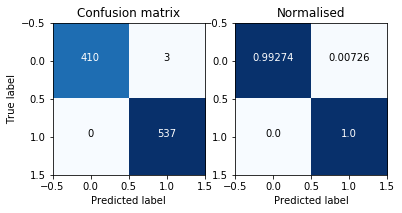



Active Region: 11875

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       559
        1.0       1.00      1.00      1.00       560

avg / total       1.00      1.00      1.00      1119



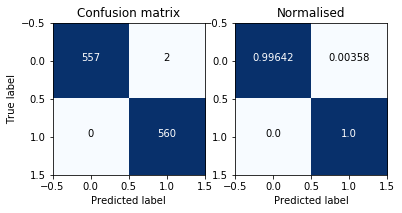



Active Region: 11890

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       556
        1.0       1.00      1.00      1.00       573

avg / total       1.00      1.00      1.00      1129



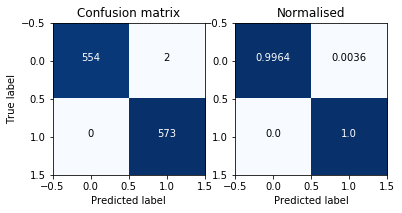



Active Region: 12002

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       813
        1.0       1.00      1.00      1.00       241

avg / total       1.00      1.00      1.00      1054



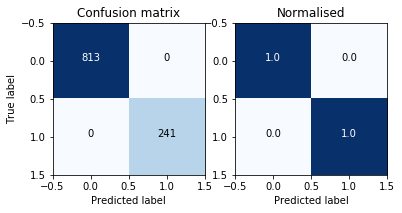



Active Region: 12192

             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95        21
        1.0       1.00      1.00      1.00       888

avg / total       1.00      1.00      1.00       909



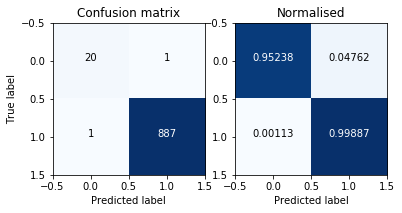



Active Region: 12297

             precision    recall  f1-score   support

        0.0       0.74      1.00      0.85        92
        1.0       1.00      0.97      0.98       950

avg / total       0.98      0.97      0.97      1042



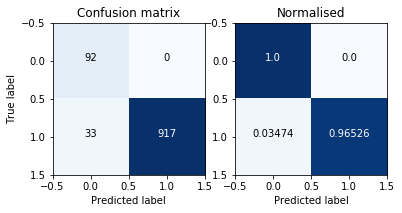

In [8]:
for ar_id in sorted(JP_RESULTS.keys()):
    
    ## Retrieve results 
    jpred = JP_RESULTS[ar_id]
    cm = jpred['cm']                ## Confusion Matrix
    cm_normalised = jpred['cmn']    ## Normalised Confusion Matrix
    labels = jpred['labels']        ## Prediction Labels 
    
    print(text_style.BOLD+'Active Region: '+ar_id+text_style.END+'\n')
    
    ## classification report i.e. precision, recall, f1-score etc.  
    print( classification_report(labels[0], labels[1]))

    ## Confusion matrix
    plt.subplot(1,2,1)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)    
    
    ## Normalised confusion matrix 
    plt.subplot(1,2,2)
    thresh = cm_normalised.max() / 2.
    for k, l in itertools.product(range(cm_normalised.shape[0]), range(cm_normalised.shape[1])):
        plt.text(l, k, round(cm_normalised[k, l],5), horizontalalignment="center", color="white" if cm_normalised[k, l] > thresh else "black")
    
    plt.imshow(cm_normalised, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalised')
    plt.xlabel('Predicted label')
    
    plt.show()
    plt.close()
    print('\n')


### CNN Predictions 

Active Region: 11158

             precision    recall  f1-score   support

          0       0.95      0.94      0.95       112
          1       0.96      0.97      0.96       167

avg / total       0.96      0.96      0.96       279



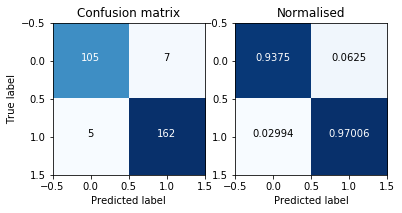



Active Region: 11875

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       164
          1       0.99      0.98      0.98       164

avg / total       0.98      0.98      0.98       328



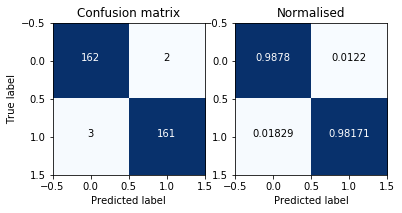



Active Region: 11890

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       158
          1       0.99      0.99      0.99       171

avg / total       0.99      0.99      0.99       329



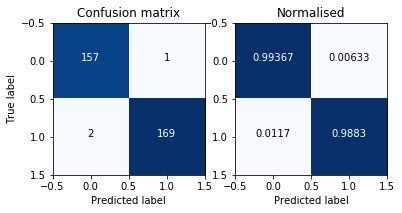



Active Region: 12002

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       227
          1       1.00      1.00      1.00        76

avg / total       1.00      1.00      1.00       303



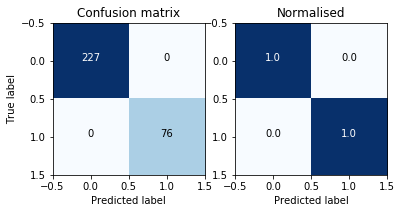



Active Region: 12192

             precision    recall  f1-score   support

          0       0.57      1.00      0.73         4
          1       1.00      0.99      0.99       264

avg / total       0.99      0.99      0.99       268



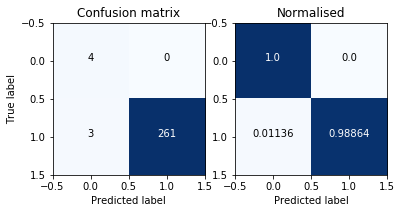



Active Region: 12297

             precision    recall  f1-score   support

          0       0.96      0.92      0.94        26
          1       0.99      1.00      0.99       276

avg / total       0.99      0.99      0.99       302



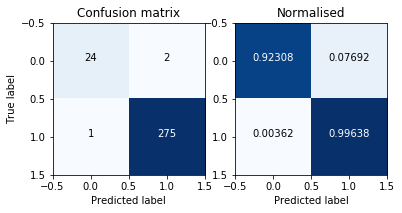

In [9]:
for ar_id in sorted(CP_RESULTS.keys()):
    
    ## Retrieve results 
    cnn_pred = CP_RESULTS[ar_id]
    cm = cnn_pred['cm']                ## Confusion Matrix
    cm_normalised = cnn_pred['cmn']    ## Normalised Confusion Matrix
    a_labels = cnn_pred['actual']      ## Actual Labels 
    p_labels = cnn_pred['preds']       ## Prediction Labels 
    
    print(text_style.BOLD+'Active Region: '+ar_id+text_style.END+'\n')
    
    ## classification report i.e. precision, recall, f1-score etc.  
    print( classification_report(a_labels, p_labels))

    ## Confusion matrix
    plt.subplot(1,2,1)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)    
    
    ## Normalised confusion matrix 
    plt.subplot(1,2,2)
    thresh = cm_normalised.max() / 2.
    for k, l in itertools.product(range(cm_normalised.shape[0]), range(cm_normalised.shape[1])):
        plt.text(l, k, round(cm_normalised[k, l],5), horizontalalignment="center", color="white" if cm_normalised[k, l] > thresh else "black")
    
    plt.imshow(cm_normalised, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalised')
    plt.xlabel('Predicted label')
    
    plt.show()
    plt.close()
    print('\n')


---
## CNN Results Graphed
The following graph illustrates the accuracy achieved by the Convolutional Neural Network for each of the 6 active regions across 10 epochs.  

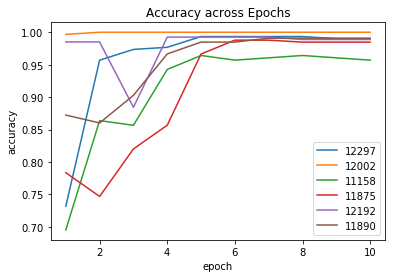

In [10]:
num_epoch = range(1,11)

for ar_id in CNN_RESULTS.keys():
    plt.plot(num_epoch, CNN_RESULTS[ar_id]['accuracy'], label=ar_id)
    
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy across Epochs')
plt.legend()
plt.show()

While the following graph illustrates the decrease in loss across the 10 epochs.  

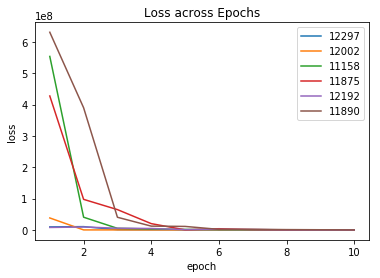

In [11]:
num_epoch = range(1,11)

for ar_id in CNN_RESULTS.keys():
    plt.plot(num_epoch, CNN_RESULTS[ar_id]['loss'], label=ar_id)
    
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss across Epochs')
plt.legend()
plt.show()

--- 

# CNN Prediction - All Active Regions 

Finally, the following is a selected example of the type of results the CNN achieves when using all 12 active regions.  However, the results vary according to the selected hyper-parameters.  The selected hyper-parameters in this example included:

* 3 Hidden Layers 
  * 1st Layer - 2500 nodes 
  * 2nd Layer - 1500 nodes 
  * 3rd Layer - 500 nodes 
* Number of epochs was 20 

The dataset for this test was split into training and test sets with 8 active regions (4 flaring AR, 4 non-flaring AR ) being selected for training and 4 for testing (2 flaring AR, 2 non-flaring AR) resulting in the following:

In [12]:
split_data = CNN_FULL_PRED['split_data']
print('\t\t\t\tNumber of images in training set: '+str(split_data['train_size']))
print('\t\t\t\tNumber of images in test set: '+str(split_data['test_size']))
print('\n\t\t\t\tNumber of flare observations in training set: '+str(split_data['train_obs']))
print('\t\t\t\tNumber of flare observations in test set: '+str(split_data['test_obs']))

				Number of images in training set: 8823
				Number of images in test set: 4445

				Number of flare observations in training set: 2948
				Number of flare observations in test set: 801


The following graph illustrates the accuracy across the 20 epochs.  

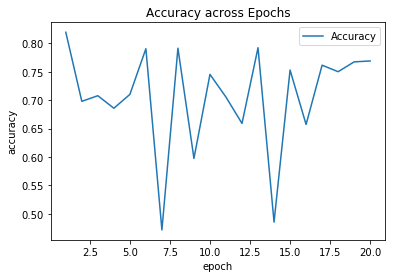

In [13]:
num_epoch = range(1,21)
plt.plot(num_epoch, CNN_FULL_PRED['accuracy'], label='Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy across Epochs')
plt.legend()
plt.show()

While the final graph here illustrates the decrease in loss across the 20 epochs.  

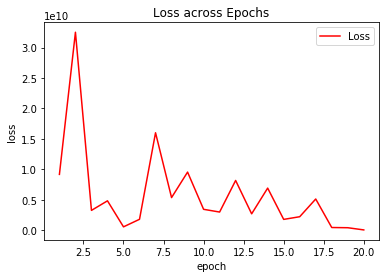

In [14]:
num_epoch = range(1,21)
plt.plot(num_epoch, CNN_FULL_PRED['loss'], color='r', label='Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss across Epochs')
plt.legend()
plt.show()

---
# Moving on ...  

Upon completing this initial stage I have a few questions  

* Confirmation my data analysis is correct ?
* Is my understanding of the labels provided by Jordan correct ?
* Can I get access to algorithmic predictions of flare activities ? 
* Would it be possible to obtain more labelled data of flare events so I can improve the training ?